# Анализ ревью на фильмы с Letterboxd

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import string

import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize
import umap.umap_ as umap

## Введение
Интересно, можно ли предсказать, какую оценку поставит пользователь, основываясь на его отзыве? Я хочу это проверить, поэтому я решила взять ревью на три самых нашумевших фильма последних лет (Анора, Субстанция и Бедные-несчастные) из популярной соцсети для любителей кино, Letterboxd. Такое предсказание можно использовать для того, чтобы помогать пользователям определяться с оценкой.
**Цель**: Подобрать наилучший инструмент для предсказания оценки фильма по ревью.
### Задачи
1. Написать парсер, чтобы собрать ревью с Letterboxd
2. Сохранить ревью в базу данных
3. Разведочный анализ данных
4. Векторизовать тексты разными способами: Bert, TF-IDF
5. Кластеризовать отзывы. Посмотреть, отзывы больше схожи между собой по эмоциональной окраске или по фильму
6. Обучить классификатор по оценкам (Логистическая регрессия, Дообучение предобученной нейронки)
7. Классифицировать по тональным спискам
8. Сравнить результаты

Я уже провела парсинг сайта и сохранила все файлы в базу данных с двумя таблицами: фильмы и отзывы

## Разведочный анализ данных

Скачаем все данные из базы данных

In [230]:
con = sqlite3.connect("/Users/mac/Desktop/vscode/project_letterboxd_analysis/letterboxd_project.sqlite")
cur = con.cursor()
result = cur.execute('SELECT text, film_id, rating FROM reviews').fetchall()
result[:4]

[('It was fun to watch but best movie oscarr??? No way. Cinematicly well shot but still an average movie. First hour goes by just sex literally nothing happens.( okay ı know she is a sex worker but still!! One hour is too much) They both didn’t love each other and have their benefit. And also did she really expect something from that LITTLE twinkie boy? And Igor was so weird ı liked him.',
  3,
  6),
 ('I just got to accept the fact that, this is my favourite movie.', 3, 10),
 ('Not my type of movie, I guess.', 3, 6),
 ('Went from music video to an office episode to a depressive episode and a criticism to both masculinity and femininity alike. Very fun watch',
  3,
  9)]

In [231]:
df = pd.DataFrame(result, columns=['text', 'film_id', 'rating'])
df

text  film_id  rating
0     It was fun to watch but best movie oscarr??? N...        3       6
1     I just got to accept the fact that, this is my...        3      10
2                        Not my type of movie, I guess.        3       6
3     Went from music video to an office episode to ...        3       9
4     Was quite funny once it got past the first 30 ...        3       4
...                                                 ...      ...     ...
4995                 girl i even understand you but wtf        2       8
4996  forgot to review upon first watch (oops) but i...        2       8
4997  I made the mistake of eating dinner during Den...        2       8
4998  MentalStrangely I got definite Dr. Suess vibes...        2       7
4999  me personally? i thought Monstroelisasue was b...        2       7

[5000 rows x 3 columns]

Всего у нас есть выборка из 5000 отзывов на фильмы. Посмотрим, сколько отзывов на каждый фильм у нас есть

In [232]:
df.value_counts('film_id')

film_id
3    1922
2    1545
1    1533
Name: count, dtype: int64

Распределение примерно равное. На Анору отзывов больше, чем на остальные, но это не критично. Теперь посмотрим, как распределены оценки

In [233]:
df.value_counts('rating')

rating
8     1343
10     955
9      797
7      657
6      560
5      222
4      213
2       93
1       81
3       79
Name: count, dtype: int64

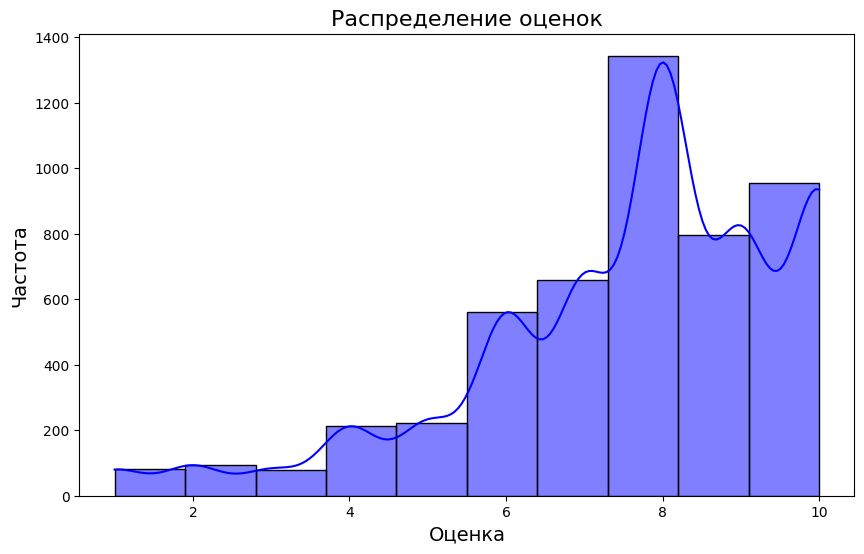

In [234]:
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], kde=True, bins=10, color='blue')
plt.title('Распределение оценок', fontsize=16)
plt.xlabel('Оценка', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.show()

Тут всё не так хорошо. Распределение сильно скошено в сторону высоких оценок. Это может повлиять на результат таким образом, что модель не будет распознавать низкие оценки. Поэтому для задачи классификации стоит разбить не на 10 классов в соответствии с рейтингом, а на 3 условных класса: низкие оценки (1-5), средние (6-7) и высокие (8-10).

In [235]:
labels = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 2, 9: 2, 10: 2}
df['class'] = df['rating'].map(labels)
df.value_counts('class')

class
2    3095
1    1217
0     688
Name: count, dtype: int64

Чуть лучше, пока оставим так. Посмотрим, похоже ли распределение для всех трёх фильмов

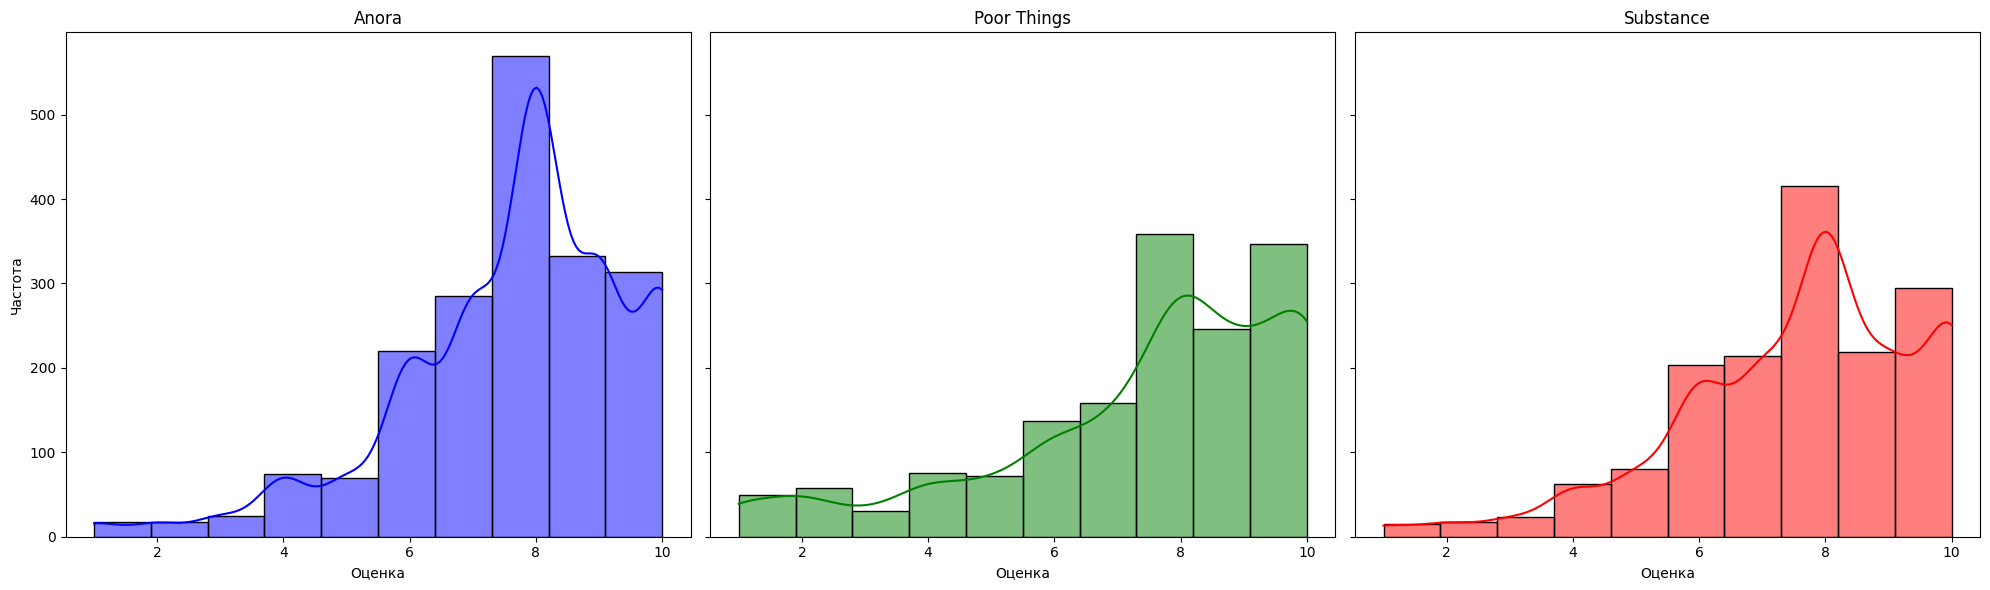

In [236]:
anora = df.loc[df['film_id'] == 3]
poorthings = df.loc[df['film_id'] == 1]
substance = df.loc[df['film_id'] == 2]
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Anora
sns.histplot(anora['rating'], kde=True, bins=10, color='blue', ax=axes[0])
axes[0].set_title('Anora')
axes[0].set_xlabel('Оценка')
axes[0].set_ylabel('Частота')

# Poor Things
sns.histplot(poorthings['rating'], kde=True, bins=10, color='green', ax=axes[1])
axes[1].set_title('Poor Things')
axes[1].set_xlabel('Оценка')

# Substance
sns.histplot(substance['rating'], kde=True, bins=10, color='red', ax=axes[2])
axes[2].set_title('Substance')
axes[2].set_xlabel('Оценка')

plt.tight_layout()
plt.show()

Да, ситуация действительно похожа для всех трёх фильмов

## Векторизация

Теперь векторизуем тексты двумя способами: Бертом и TF-IDF

### Bert

In [237]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

In [238]:
def get_embedding(text, if_cls=1):
    """
    Получает эмбеддинги либо для текста, либо потокенно
    """
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    
    if if_cls:
        # Извлекаем последний скрытый слой [CLS] токена (представление для всего текста)
        last_hidden_states = outputs.last_hidden_state
        # Берём эмбеддинг [CLS] токена, который является эмбеддингом всего текста
        text_embedding = last_hidden_states[:, 0, :].squeeze().numpy()
        return text_embedding
    else:
        # Извлекаем все скрытые состояния
        hidden_states = outputs.last_hidden_state.squeeze().numpy()
        # Получаем эмбеддинг для каждого слова (токена)
        token_embeddings = hidden_states
        return token_embeddings

In [239]:
tqdm.pandas()
df['text_embedding'] = df['text'].progress_apply(get_embedding)

100%|██████████| 5000/5000 [03:18<00:00, 25.19it/s]


In [240]:
df

text  film_id  rating  \
0     It was fun to watch but best movie oscarr??? N...        3       6   
1     I just got to accept the fact that, this is my...        3      10   
2                        Not my type of movie, I guess.        3       6   
3     Went from music video to an office episode to ...        3       9   
4     Was quite funny once it got past the first 30 ...        3       4   
...                                                 ...      ...     ...   
4995                 girl i even understand you but wtf        2       8   
4996  forgot to review upon first watch (oops) but i...        2       8   
4997  I made the mistake of eating dinner during Den...        2       8   
4998  MentalStrangely I got definite Dr. Suess vibes...        2       7   
4999  me personally? i thought Monstroelisasue was b...        2       7   

      class                                     text_embedding  
0         1  [0.16634671, -0.3294138, 0.20103772, 0.0660809...  
1         2  [0.16508035, 0.09904756, -0.03573228, -0.31135...  
2         1  [-0.06929839, -0.30265427, -0.15834926, -0.227...  
3         2  [-0.049740523, -0.1901305, -0.27690116, -0.119...  
4         0  [-0.055833794, -0.017750219, 0.20417628, 0.153...  
...     ...                                                ...  
4995      2  [-0.23133132, 0.24502644, -0.1052718, -0.08971...  
4996      2  [0.02351629, -0.34568694, -0.073115274, -0.062...  
4997      2  [0.04355067, 0.2573567, -0.25289825, -0.178085...  
4998      1  [0.06101226, -0.022053743, 0.30589014, -0.0705...  
4999      1  [-0.02115348, -0.015282836, -0.22109488, 0.093...  

[5000 rows x 5 columns]

### TF-IDF

In [241]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    """
    Предобрабатывает текст: приводит к нижнему регистру, чистит от пунктуации и стоп-слов и лемматизирует
    """
    # Приведение к нижнему регистру
    text = text.lower().replace('\n', ' ')

    # Удаление пунктуации
    text = ''.join([char for char in text if char not in string.punctuation])

    # Токенизация
    tokens = wordpunct_tokenize(text)

    # Удаление стоп-слов (опционально)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Лемматизация
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

In [243]:
df['cleaned_text'] = df['text'].apply(preprocess_text)
df

text  film_id  rating  \
0     It was fun to watch but best movie oscarr??? N...        3       6   
1     I just got to accept the fact that, this is my...        3      10   
2                        Not my type of movie, I guess.        3       6   
3     Went from music video to an office episode to ...        3       9   
4     Was quite funny once it got past the first 30 ...        3       4   
...                                                 ...      ...     ...   
4995                 girl i even understand you but wtf        2       8   
4996  forgot to review upon first watch (oops) but i...        2       8   
4997  I made the mistake of eating dinner during Den...        2       8   
4998  MentalStrangely I got definite Dr. Suess vibes...        2       7   
4999  me personally? i thought Monstroelisasue was b...        2       7   

      class                                     text_embedding  \
0         1  [0.16634671, -0.3294138, 0.20103772, 0.0660809...   
1         2  [0.16508035, 0.09904756, -0.03573228, -0.31135...   
2         1  [-0.06929839, -0.30265427, -0.15834926, -0.227...   
3         2  [-0.049740523, -0.1901305, -0.27690116, -0.119...   
4         0  [-0.055833794, -0.017750219, 0.20417628, 0.153...   
...     ...                                                ...   
4995      2  [-0.23133132, 0.24502644, -0.1052718, -0.08971...   
4996      2  [0.02351629, -0.34568694, -0.073115274, -0.062...   
4997      2  [0.04355067, 0.2573567, -0.25289825, -0.178085...   
4998      1  [0.06101226, -0.022053743, 0.30589014, -0.0705...   
4999      1  [-0.02115348, -0.015282836, -0.22109488, 0.093...   

                                           cleaned_text  
0     fun watch best movie oscarr way cinematicly we...  
1                       got accept fact favourite movie  
2                                      type movie guess  
3     went music video office episode depressive epi...  
4                quite funny got past first 30 minute …  
...                                                 ...  
4995                           girl even understand wtf  
4996  forgot review upon first watch oops loved movi...  
4997  made mistake eating dinner dennis quaids shrim...  
4998  mentalstrangely got definite dr suess vibe esp...  
4999   personally thought monstroelisasue beautiful way  

[5000 rows x 6 columns]

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['cleaned_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

## Кластеризация

Попробуем визуализировать получившиеся вектора. Но для этого нужно снизить размерность до 2-х. Попробуем два метода снижения размерности (t-SNE и UMAP) и два параметра окрашивания (фильмы и тональные классы)

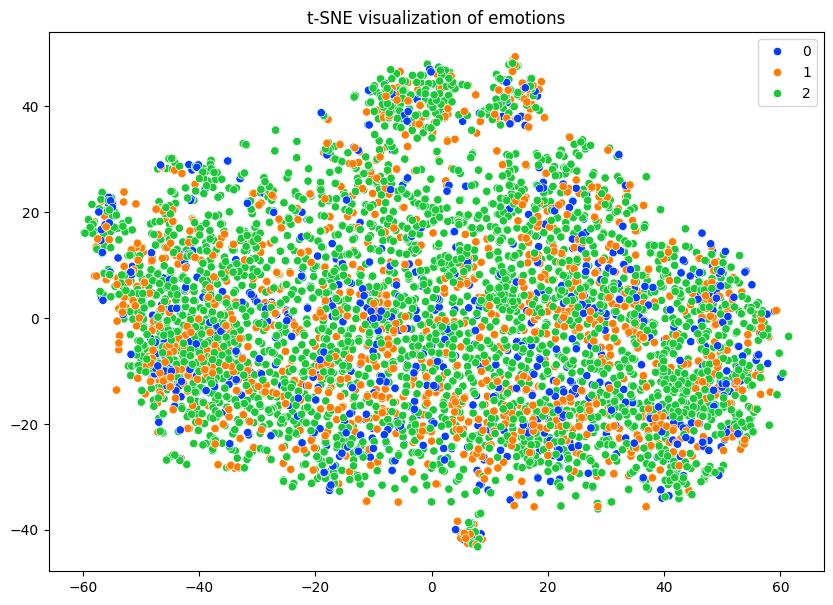

In [245]:
x = np.vstack(df['text_embedding'].values)
y = df['class'].values
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(x)
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='bright')
plt.title('t-SNE visualization of emotions')
plt.show()

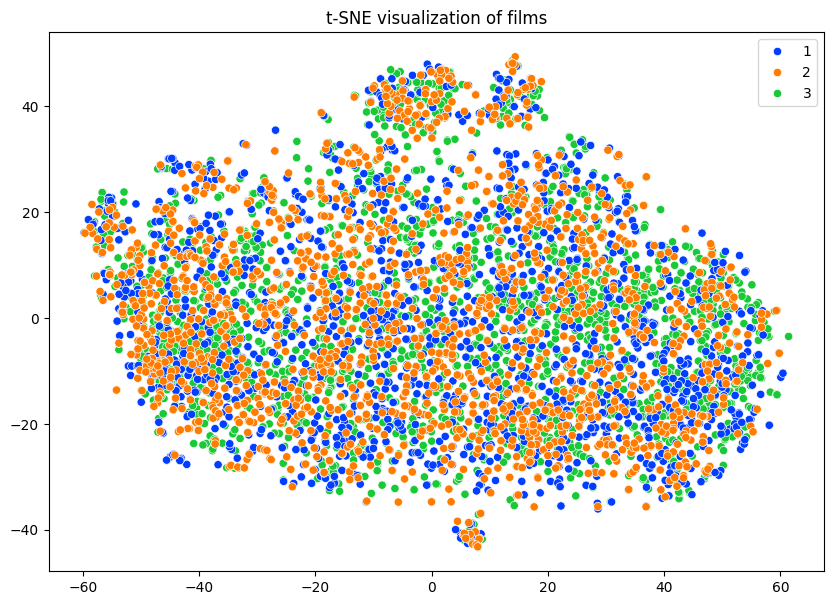

In [246]:
x = np.vstack(df['text_embedding'].values)
y = df['film_id'].values
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(x)
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y, palette='bright')
plt.title('t-SNE visualization of films')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


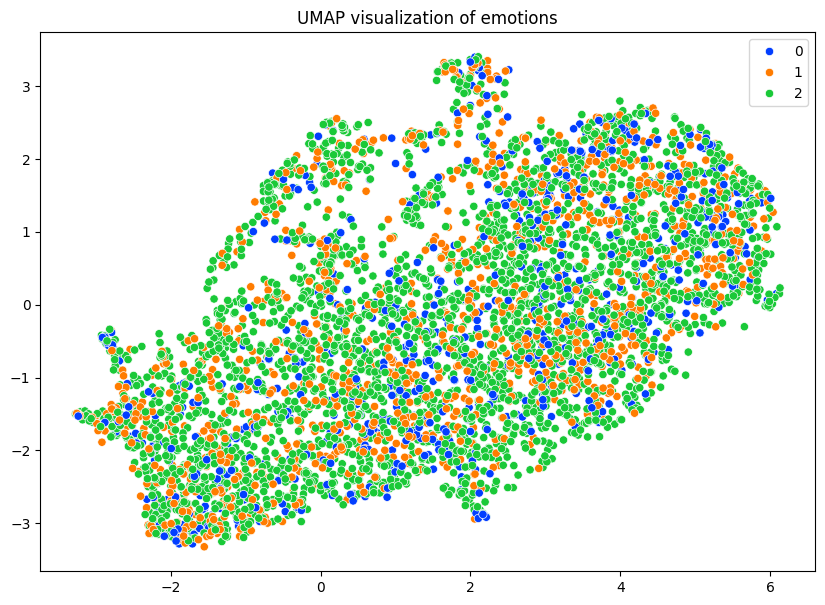

In [247]:
reducer = umap.UMAP(n_components=2)
y = df['class'].values
x_umap = reducer.fit_transform(x)

plt.figure(figsize=(10,7))
sns.scatterplot(x=x_umap[:,0], y=x_umap[:,1], hue=y, palette='bright')
plt.title('UMAP visualization of emotions')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


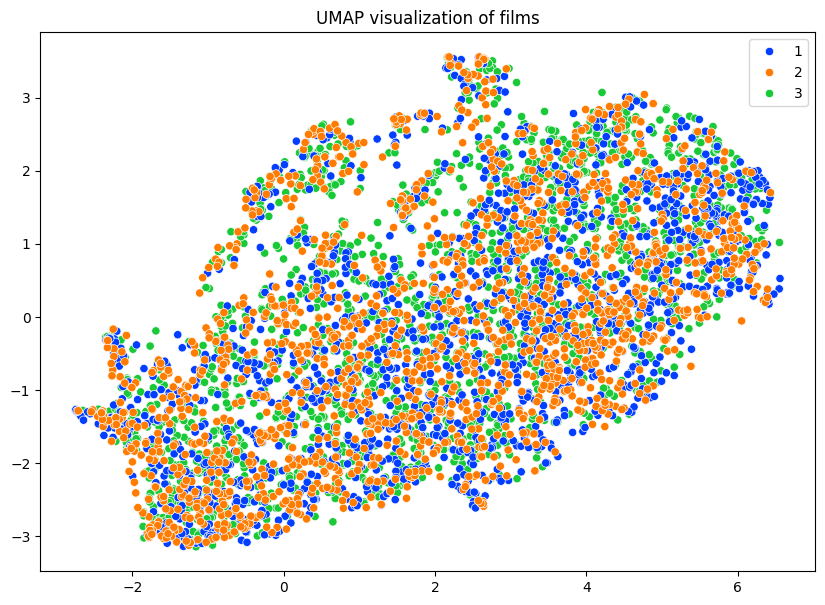

In [248]:
reducer = umap.UMAP(n_components=2)
y = df['film_id'].values
x_umap = reducer.fit_transform(x)

plt.figure(figsize=(10,7))
sns.scatterplot(x=x_umap[:,0], y=x_umap[:,1], hue=y, palette='bright')
plt.title('UMAP visualization of films')
plt.show()

Никаких кластеров на визуализации не видно. Скорее всего на таких данных будет невозможно сделать качественную кластеризацию. Собственно, вероятно, это же и причина, почему может не получиться добиться высокой точности предсказаний.

In [249]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(x)

Для оценки качества используем метрику Silhouette Score. Её суть заключается в том, что она измеряет, насколько хорошо каждый объект принадлежит своему кластеру и насколько он отделён от других кластеров. Рассчитывается по такой формуле:
$$ s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))} $$
где a(i) — среднее расстояние от точки i до всех других точек в том же кластере, а b(i) — минимальное среднее расстояние от точки i до точек в ближайшем другом кластере.

In [250]:
score = silhouette_score(x, kmeans_labels)
print(f'Silhouette Score: {score:.4f}')

Silhouette Score: 0.0799


Чем ближе метрика к 1, тем лучше. как мы видим, всё довольно плохо) Посмотрим, как выглядит результат кластеризации

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


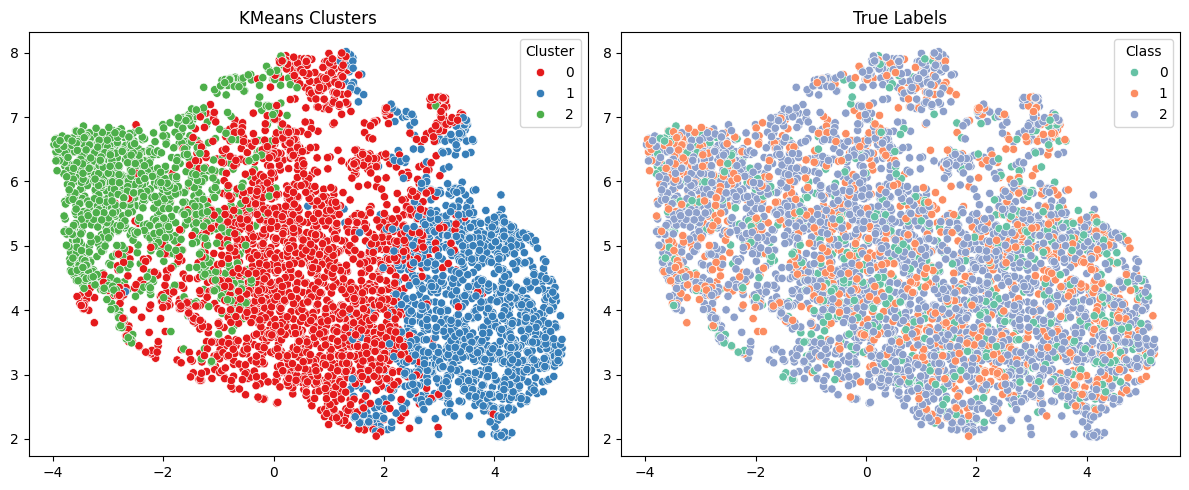

In [251]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(x)
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=kmeans_labels, palette='Set1')
plt.title('KMeans Clusters')
plt.legend(title='Cluster')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df['class'], palette='Set2')
plt.title('True Labels')
plt.legend(title='Class')

plt.tight_layout()
plt.show()

Ну, он пытался...

## Логистическая регрессия

Всё же попробуем обучить классификаторы на основе этих данных. Начнём с логистической регрессии

In [252]:
x = np.vstack(df['text_embedding'].values)
y = df['class']

In [253]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [254]:
clf = LogisticRegression()
clf.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [255]:
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.36      0.38       170
           1       0.41      0.29      0.34       305
           2       0.70      0.80      0.75       775

    accuracy                           0.62      1250
   macro avg       0.50      0.48      0.49      1250
weighted avg       0.59      0.62      0.60      1250



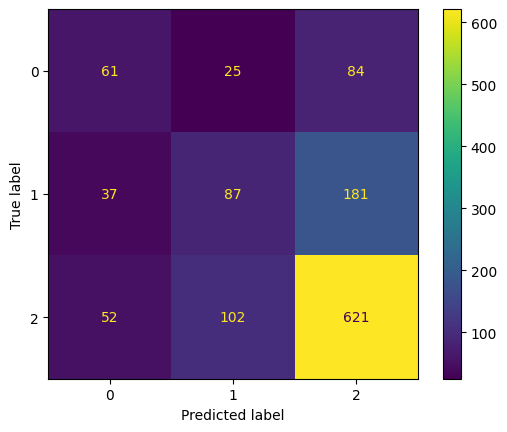

In [256]:
matrix = confusion_matrix(y_test, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()

Нормально, но всё же надо лучше. Попробуем теперь с векторами tf-idf

In [257]:
x = df['cleaned_text']
y = df['class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Ограничиваем количество признаков
X_train_tfidf = vectorizer.fit_transform(x_train)  # Векторизуем обучающие данные
X_test_tfidf = vectorizer.transform(x_test)  # Векторизуем тестовые данные

# Обучаем логистическую регрессию
model = LogisticRegression(max_iter=1000)  # Увеличиваем количество итераций для более сложных данных
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.15      0.24       170
           1       0.47      0.22      0.30       305
           2       0.67      0.91      0.77       775

    accuracy                           0.64      1250
   macro avg       0.56      0.43      0.44      1250
weighted avg       0.60      0.64      0.58      1250



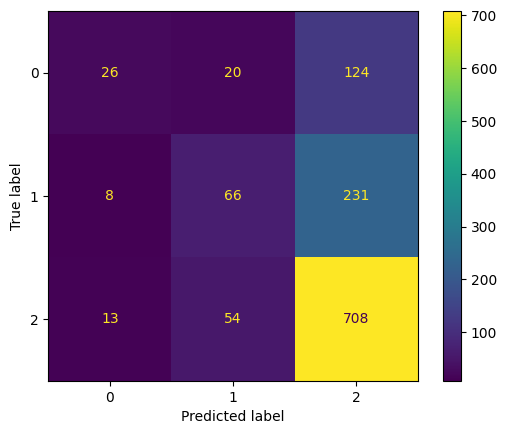

In [258]:
matrix = confusion_matrix(y_test, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()

Особо лучше не стало. Модель в обоих случаях стремится скинуть все предсказания в самый частотный класс. Только с векторами tf-idf стало ещё больше ложно положительных предсказаний. Попробуем усовершенствовать логистическую регрессию через grid search. Попробуем на обоих векторах. Начнём с Берта

In [259]:
x = np.vstack(df['text_embedding'].values)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [260]:
parameters = {
    'penalty': ['l1', 'l2', None],  # тип регуляризация
    'C':[1, 10],  # обратная сила регуляризации
    'fit_intercept': [True, False]  # со смещением или без
}
logreg = LogisticRegression(solver='saga', random_state=42)
clf = GridSearchCV(logreg, parameters, cv=5, verbose=1)
clf.fit(x_train, y_train)
cv_res = pd.DataFrame(clf.cv_results_)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']]
cv_res.sort_values('rank_test_score').style

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

In [261]:
clf = LogisticRegression(
    C=1,
    penalty='l1',
    fit_intercept=True,
    solver='saga'
)

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.36      0.41       170
           1       0.42      0.27      0.33       305
           2       0.70      0.83      0.76       775

    accuracy                           0.63      1250
   macro avg       0.53      0.49      0.50      1250
weighted avg       0.60      0.63      0.61      1250



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Теперь то же самое с векторамии tf-idf

In [262]:
x = df['cleaned_text']
y = df['class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Ограничиваем количество признаков
X_train_tfidf = vectorizer.fit_transform(x_train)  # Векторизуем обучающие данные
X_test_tfidf = vectorizer.transform(x_test)  # Векторизуем тестовые данные
logreg = LogisticRegression(solver='saga', random_state=42)
clf = GridSearchCV(logreg, parameters, cv=5, verbose=1)
clf.fit(X_train_tfidf, y_train)
cv_res = pd.DataFrame(clf.cv_results_)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']]
cv_res.sort_values('rank_test_score').style

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

In [263]:
clf = LogisticRegression(
    C=1,
    penalty='l1',
    fit_intercept=True,
    solver='saga'
)

clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.12      0.20       170
           1       0.44      0.17      0.24       305
           2       0.65      0.92      0.76       775

    accuracy                           0.63      1250
   macro avg       0.54      0.40      0.40      1250
weighted avg       0.58      0.63      0.56      1250



In [264]:
vectorizer = TfidfVectorizer(
    max_df=0.9,       # убираем слишком частые слова
    min_df=5,         # убираем редкие слова
    ngram_range=(1,2),# используем униграммы + биграммы
    max_features=10000,  # ограничиваем размер словаря
    stop_words='english'
)

X_tfidf = vectorizer.fit_transform(df['cleaned_text'])
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['class'], test_size=0.2, stratify=df['class'])

clf = LogisticRegression(class_weight='balanced', max_iter=1000, C=1.0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.44      0.36       138
           1       0.34      0.42      0.37       243
           2       0.74      0.60      0.67       619

    accuracy                           0.54      1000
   macro avg       0.46      0.49      0.47      1000
weighted avg       0.58      0.54      0.55      1000



Изменение параметров не помогло (разве что чуть-чуть повысили f1-score). Для обоих наборов векторов оптимальными оказались параметры: со смещением и регуляризация L1, с обратной силой регуляризации 1. Но есть ещё вариант, как улучшить модель. Можно использовать Берта не для эмбеддингов, а дообучить его на моих данных для решения задачи классификации

## Дообучение Берта

In [265]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

dataset = Dataset.from_pandas(df[['text', 'class']])
dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.rename_column("class", "labels")
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_test = dataset.train_test_split(test_size=0.25)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [266]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [267]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test['train'],
    eval_dataset=train_test['test'],
)

trainer.train()

TrainOutput(global_step=705, training_loss=0.7182785142398049, metrics={'train_runtime': 283.6346, 'train_samples_per_second': 39.664, 'train_steps_per_second': 2.486, 'total_flos': 740006487360000.0, 'train_loss': 0.7182785142398049, 'epoch': 3.0})

In [268]:
trainer.evaluate()

{'eval_loss': 0.8214458227157593,
 'eval_runtime': 7.2813,
 'eval_samples_per_second': 171.672,
 'eval_steps_per_second': 10.85,
 'epoch': 3.0}

Обучили. Теперь предсказываем и оцениваем качество.

In [269]:
predictions = trainer.predict(train_test['test'])
y_true = train_test['test']['labels']
y_pred = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.39      0.43       156
           1       0.43      0.25      0.32       323
           2       0.72      0.88      0.79       771

    accuracy                           0.66      1250
   macro avg       0.55      0.51      0.52      1250
weighted avg       0.62      0.66      0.63      1250



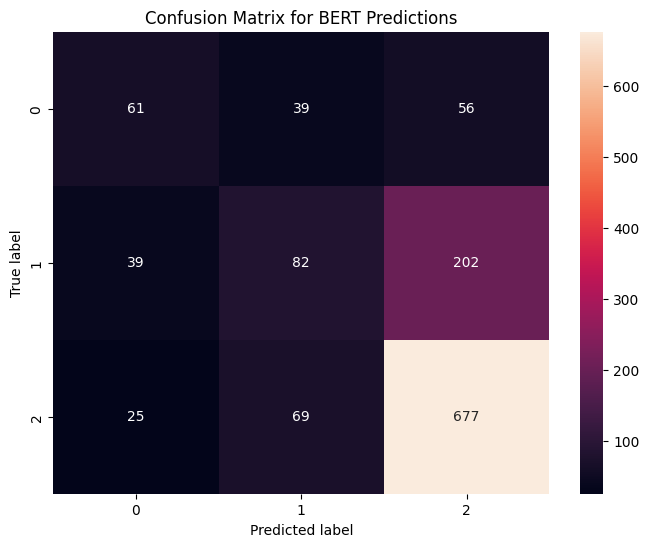

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for BERT Predictions')
plt.show()

Совсем немного, но стало лучше. Сильно путаются положительный и нейтральный классы. Поэтому, возможно, стоит разделить данные не на три класса, а на два: положительный и отрицательный. Тогда и выборка будет сбаллансированнее, и классификация проще.

In [271]:
labels_2 = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1}
df['class_bin'] = df['rating'].map(labels_2)
df.value_counts('class_bin')

class_bin
1    3752
0    1248
Name: count, dtype: int64

Выборка настолько несбаллансированная, что даже такое разбиение не помогает. Может, хотя бы простота классификации улучшит ситуацию.

In [273]:
dataset = Dataset.from_pandas(df[['text', 'class_bin']])
dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.rename_column("class_bin", "labels")
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_test = dataset.train_test_split(test_size=0.25)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [274]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [275]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test['train'],
    eval_dataset=train_test['test'],
)

trainer.train()

TrainOutput(global_step=705, training_loss=0.4073105940582059, metrics={'train_runtime': 283.1809, 'train_samples_per_second': 39.727, 'train_steps_per_second': 2.49, 'total_flos': 739999843200000.0, 'train_loss': 0.4073105940582059, 'epoch': 3.0})

In [276]:
trainer.evaluate()

{'eval_loss': 0.5279172658920288,
 'eval_runtime': 8.2117,
 'eval_samples_per_second': 152.221,
 'eval_steps_per_second': 9.62,
 'epoch': 3.0}

In [277]:
predictions = trainer.predict(train_test['test'])
y_true = train_test['test']['labels']
y_pred = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.44      0.50       296
           1       0.84      0.90      0.87       954

    accuracy                           0.79      1250
   macro avg       0.71      0.67      0.69      1250
weighted avg       0.78      0.79      0.78      1250



Да! С бинарной классификацией модель действительно справилась лучше.

## Decision tree

Попробуем ещё один классификатор: Дерево решений

In [279]:
x = np.vstack(df['text_embedding'].values)
y = df['class_bin']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [280]:
clf_gini = DecisionTreeClassifier(
    criterion='gini',
    max_depth=6,
    random_state=0
    )   

In [281]:
clf_gini.fit(x_train, y_train)
y_pred = clf_gini.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.22      0.28       314
           1       0.77      0.88      0.82       936

    accuracy                           0.72      1250
   macro avg       0.58      0.55      0.55      1250
weighted avg       0.67      0.72      0.69      1250



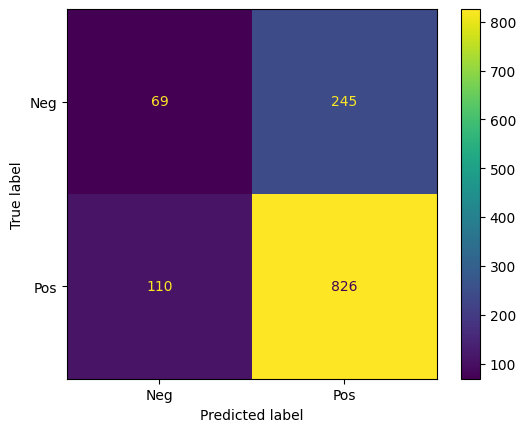

In [283]:
matrix = confusion_matrix(y_test, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Neg', 'Pos'])
disp.plot()

C бинарной классификацией неплохо справляется даже такая простенькая модель как дерево решений. Но всё же хуже, чем классификатор Берта

## Wordlist-based подход

Я попробовала определять тональность комментариев с помощью машинного обучения, а теперь попробую решить эту задачу старым методом, который использовался до появления машинного обучения: словари оценочной лексики. Есть библиотека для определения тональности текста, как раз оперирующая wordlist-based подходом.

In [284]:
import afinn

Разметим все тексты этим подходом

In [285]:
afinn = afinn.Afinn()
afinn_scores = [afinn.score(text) for text in df['text']]
df['afinn'] = afinn_scores
df

text  film_id  rating  \
0     It was fun to watch but best movie oscarr??? N...        3       6   
1     I just got to accept the fact that, this is my...        3      10   
2                        Not my type of movie, I guess.        3       6   
3     Went from music video to an office episode to ...        3       9   
4     Was quite funny once it got past the first 30 ...        3       4   
...                                                 ...      ...     ...   
4995                 girl i even understand you but wtf        2       8   
4996  forgot to review upon first watch (oops) but i...        2       8   
4997  I made the mistake of eating dinner during Den...        2       8   
4998  MentalStrangely I got definite Dr. Suess vibes...        2       7   
4999  me personally? i thought Monstroelisasue was b...        2       7   

      class                                     text_embedding  \
0         1  [0.16634671, -0.3294138, 0.20103772, 0.0660809...   
1         2  [0.16508035, 0.09904756, -0.03573228, -0.31135...   
2         1  [-0.06929839, -0.30265427, -0.15834926, -0.227...   
3         2  [-0.049740523, -0.1901305, -0.27690116, -0.119...   
4         0  [-0.055833794, -0.017750219, 0.20417628, 0.153...   
...     ...                                                ...   
4995      2  [-0.23133132, 0.24502644, -0.1052718, -0.08971...   
4996      2  [0.02351629, -0.34568694, -0.073115274, -0.062...   
4997      2  [0.04355067, 0.2573567, -0.25289825, -0.178085...   
4998      1  [0.06101226, -0.022053743, 0.30589014, -0.0705...   
4999      1  [-0.02115348, -0.015282836, -0.22109488, 0.093...   

                                           cleaned_text  class_bin  afinn  
0     fun watch best movie oscarr way cinematicly we...          0   11.0  
1                       got accept fact favourite movie          1    3.0  
2                                      type movie guess          0    0.0  
3     went music video office episode depressive epi...          1    2.0  
4                quite funny got past first 30 minute …          0    4.0  
...                                                 ...        ...    ...  
4995                           girl even understand wtf          1   -4.0  
4996  forgot review upon first watch oops loved movi...          1    3.0  
4997  made mistake eating dinner dennis quaids shrim...          1   -2.0  
4998  mentalstrangely got definite dr suess vibe esp...          1    8.0  
4999   personally thought monstroelisasue beautiful way          1    3.0  

[5000 rows x 8 columns]

In [289]:
df['afinn'].value_counts().sort_index()

afinn
-37.0    1
-34.0    1
-32.0    1
-31.0    1
-30.0    2
        ..
 57.0    2
 60.0    1
 61.0    1
 73.0    1
 85.0    1
Name: count, Length: 78, dtype: int64

Итак, мы получили тональную оценку текстов по шкале со значениями от -37 до 85, где отрицательные значения показывают негативную окраску, а положительные – позитивную

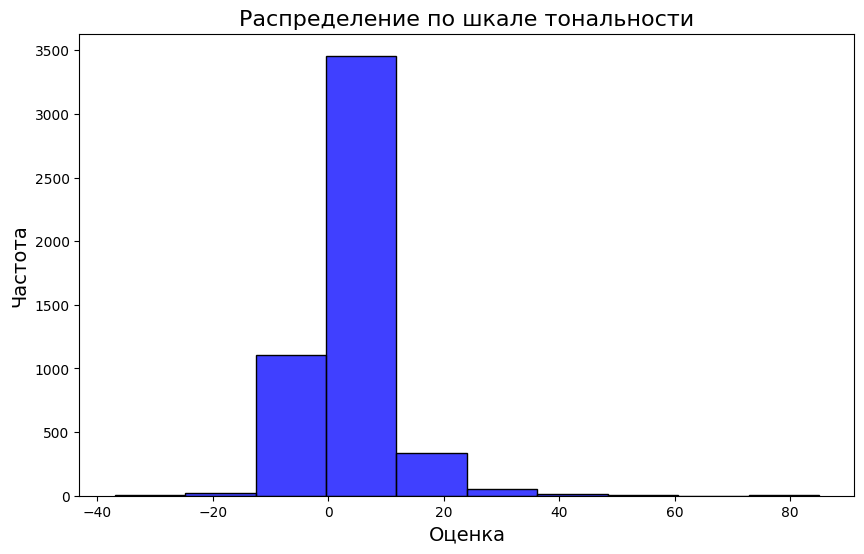

In [290]:
plt.figure(figsize=(10, 6))
sns.histplot(df['afinn'], bins=10, color='blue')
plt.title('Распределение по шкале тональности', fontsize=16)
plt.xlabel('Оценка', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.show()

Теперь надо их привести к трём условным классам для дальнейшей работы: отрицательный, положительный и нейтральный.

In [291]:
def label_sentiment(score):
    if score < 0:
        return 0
    elif score <= 10:
        return 1
    else:
        return 2

In [292]:
df['class_afinn'] = df['afinn'].apply(label_sentiment)
df

text  film_id  rating  \
0     It was fun to watch but best movie oscarr??? N...        3       6   
1     I just got to accept the fact that, this is my...        3      10   
2                        Not my type of movie, I guess.        3       6   
3     Went from music video to an office episode to ...        3       9   
4     Was quite funny once it got past the first 30 ...        3       4   
...                                                 ...      ...     ...   
4995                 girl i even understand you but wtf        2       8   
4996  forgot to review upon first watch (oops) but i...        2       8   
4997  I made the mistake of eating dinner during Den...        2       8   
4998  MentalStrangely I got definite Dr. Suess vibes...        2       7   
4999  me personally? i thought Monstroelisasue was b...        2       7   

      class                                     text_embedding  \
0         1  [0.16634671, -0.3294138, 0.20103772, 0.0660809...   
1         2  [0.16508035, 0.09904756, -0.03573228, -0.31135...   
2         1  [-0.06929839, -0.30265427, -0.15834926, -0.227...   
3         2  [-0.049740523, -0.1901305, -0.27690116, -0.119...   
4         0  [-0.055833794, -0.017750219, 0.20417628, 0.153...   
...     ...                                                ...   
4995      2  [-0.23133132, 0.24502644, -0.1052718, -0.08971...   
4996      2  [0.02351629, -0.34568694, -0.073115274, -0.062...   
4997      2  [0.04355067, 0.2573567, -0.25289825, -0.178085...   
4998      1  [0.06101226, -0.022053743, 0.30589014, -0.0705...   
4999      1  [-0.02115348, -0.015282836, -0.22109488, 0.093...   

                                           cleaned_text  class_bin  afinn  \
0     fun watch best movie oscarr way cinematicly we...          0   11.0   
1                       got accept fact favourite movie          1    3.0   
2                                      type movie guess          0    0.0   
3     went music video office episode depressive epi...          1    2.0   
4                quite funny got past first 30 minute …          0    4.0   
...                                                 ...        ...    ...   
4995                           girl even understand wtf          1   -4.0   
4996  forgot review upon first watch oops loved movi...          1    3.0   
4997  made mistake eating dinner dennis quaids shrim...          1   -2.0   
4998  mentalstrangely got definite dr suess vibe esp...          1    8.0   
4999   personally thought monstroelisasue beautiful way          1    3.0   

      class_afinn  
0               2  
1               1  
2               1  
3               1  
4               1  
...           ...  
4995            0  
4996            1  
4997            0  
4998            1  
4999            1  

[5000 rows x 9 columns]

Посмотрим, как они выглядят

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


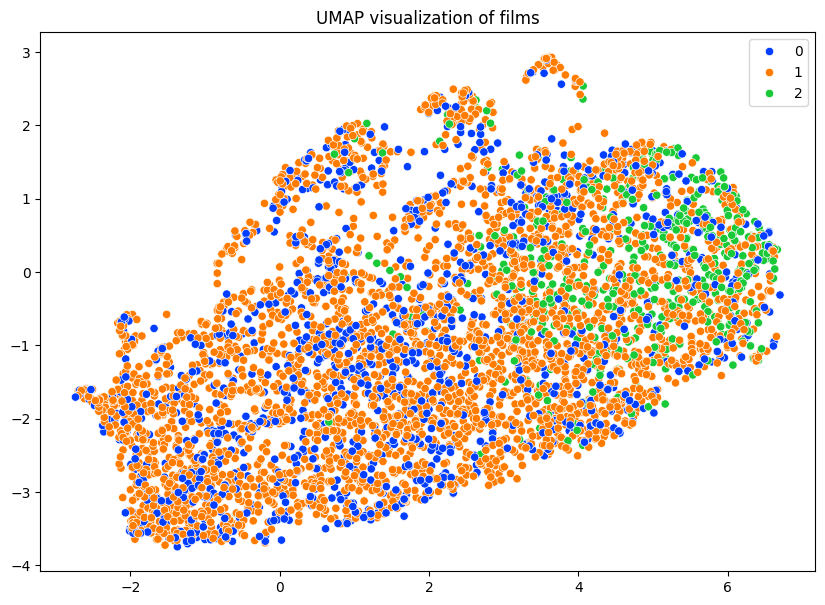

In [293]:
reducer = umap.UMAP(n_components=2)
y = df['class_afinn'].values
x_umap = reducer.fit_transform(x)

plt.figure(figsize=(10,7))
sns.scatterplot(x=x_umap[:,0], y=x_umap[:,1], hue=y, palette='bright')
plt.title('UMAP visualization of films')
plt.show()

Эта разметка выглядит более логичной, чем та, которую делали сами пользователи. Позитивный и негативный классы разделяются вполне хорошо, а вот нейтральный заполоняет всё пространство. На этой разметке будет хорошо работать кластеризация, если выкинуть нейтральный клас. Проверим, насколько эта разметка соотносится с тем, что пользователи думают про свою рецензию.

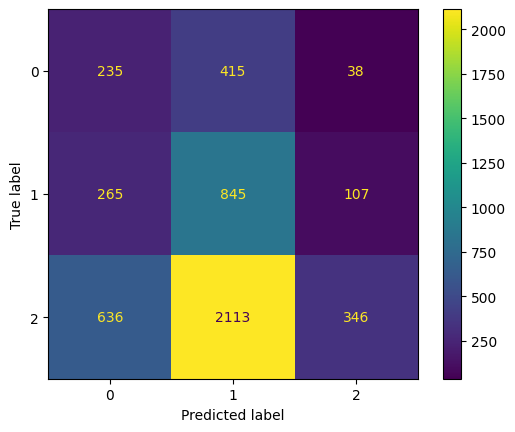

In [294]:
matrix = confusion_matrix(df['class'], df['class_afinn'], normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[0, 1, 2])
disp.plot()

Пользователи очень сильно разошлись во мнениях по поводу тональности своих отзывов с данной разметкой) Посмотрим, как обучится логистическая регрессия

In [295]:
y = df[df['class_afinn'].isin([0, 2])]['class_afinn']
x = np.vstack(df[df['class_afinn'].isin([0, 2])]['text_embedding'].values)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [296]:
clf = LogisticRegression(
    C=1,
    penalty='l1',
    fit_intercept=True,
    solver='saga'
)

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       283
           2       0.82      0.89      0.85       124

    accuracy                           0.91       407
   macro avg       0.88      0.90      0.89       407
weighted avg       0.91      0.91      0.91       407



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Очевидно, классификация будет очень хорошая, если из выборки просто выкинуть все нейтральные классы) Но так, конечно, делать нельзя. А кластеризация?

In [300]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(x)
score = silhouette_score(x, kmeans_labels)
print(f'Silhouette Score: {score:.4f}')

Silhouette Score: 0.1530


Эта метрика всё ещё плохая, потому что в реальности кластеры плохо разделены. Грань между положительным отзывом и отрицательным довольно размыта

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


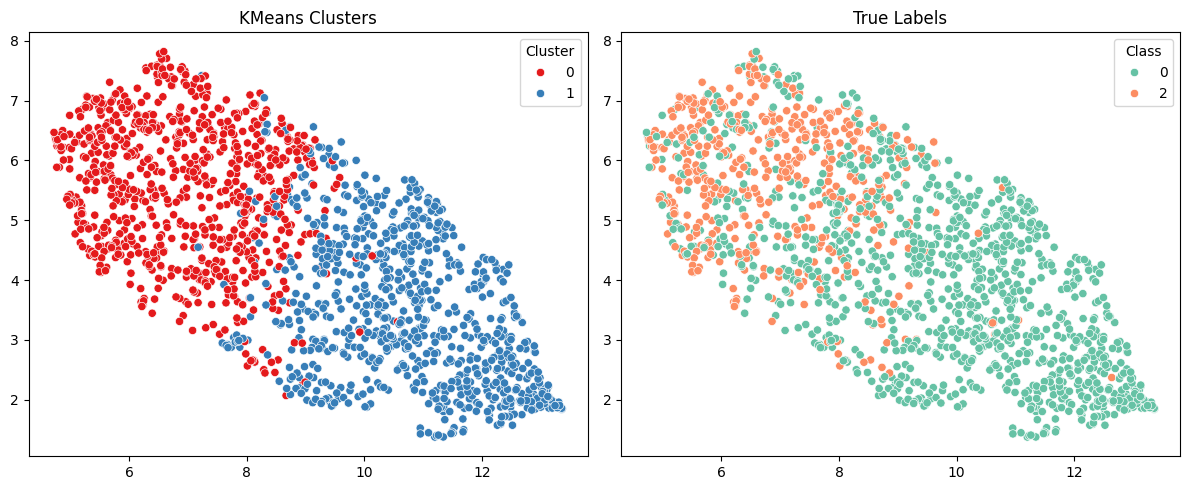

In [301]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(x)
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=kmeans_labels, palette='Set1')
plt.title('KMeans Clusters')
plt.legend(title='Cluster')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='Set2')
plt.title('True Labels')
plt.legend(title='Class')

plt.tight_layout()
plt.show()

Очень похоже на правду!

## Выводы

И так, по результатам исследования можно сделать следующие выводы:
- Лучший метод классификации – классификация Бертом
- На реальных данных лучше работает бинарная классификация. На тринарной классификации так и не удалось достичь высокой точности предсказаний, так как это реальные отзывы и оценки от пользователей. Они во-первых ставят оценки относительно отзывов не однообразно относительно друг друга, а во-вторых иногда используют сарказм, который модель никак не распознаёт
- Разметка с помощью тонального словаря более логичная и лучше поддаётся классификации, чем разметка от самих пользователей